In [1]:
#setup
data_dir ='../../Data/Weather'
file_index='SSSBSSSS'#BBBSBBBB'
m='SNWD'

## Reconstruction using top eigen-vectors
For measurement = {{m}}

## Load the required libraries

In [2]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [3]:
#%matplotlib inline
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.12.1 	required version>=1.12.0
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [4]:
from pyspark import SparkContext
# sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)





## Read Statistics File

In [5]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [6]:
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==m)
df.show(5)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     29.0| 36.9308|-121.7692|       SNWD|USC00049473|     0|[00 00 00 00 00 0...|1949.0|SSSBSSSS|
|     29.0| 36.9308|-121.7692|       SNWD|USC00049473|     0|[00 00 00 00 00 0...|1950.0|SSSBSSSS|
|     29.0| 36.9308|-121.7692|       SNWD|USC00049473|    11|[00 00 00 00 00 0...|1951.0|SSSBSSSS|
|     29.0| 36.9308|-121.7692|       SNWD|USC00049473|     3|[00 00 00 00 00 0...|1952.0|SSSBSSSS|
|     29.0| 36.9308|-121.7692|       SNWD|USC00049473|     4|[00 00 00 00 00 0...|1953.0|SSSBSSSS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



### Plot Reconstructions

Construct approximations of a time series using the mean and the $k$ top eigen-vectors
First, we plot the mean and the top $k$ eigenvectors

In [7]:
YP=YearPlotter()
def plot_pair(pair,func,metric=None):
    j=0
    fig,X=subplots(len(pair)/2,2,figsize=(20,6*len(pair)/2))
#     print X
    axes=X.reshape(len(pair))
    for m in pair:
        axis = axes[j]
        j+=1
        if not metric:
            func(m,fig,axis)
        else:
            func(m,fig,axis,metric[m],m)
def plot_single(pair,func,metric=None):
    j=0
    fig,axis=subplots(1,1,figsize=(10,6))
#     print X,fig
    if not metric:
            func(m,fig,axis)
    else:
        func(m,fig,axis,metric[m],m)
def plot_valid(m,fig,axis,metric='mean'):
    valid_m=STAT[m][metric]
    YearPlotter().plot(valid_m,fig,axis,title='mean-counts '+m)
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean,mean-std,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m,labels=['mean','mean-std','mean+std'])
def plot_mean(m,fig,axis,metric,name):
    year = metrics[name]['year'].tolist()
    metric = metrics[name]['avg(mean)'].tolist()
    year = [year[i] for i in range(0,len(year)-1,2)]
    metric = [(metric[i]+metric[i+1])*1.0/2 for i in range(0,len(metric)-1,2)]
    axis.plot(year,metric)
    axis.set_title(name)
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
#     plt.show()
#     YP.plot(metric,fig,axis,title=name)


In [8]:
import pylab as plt

k=3
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']



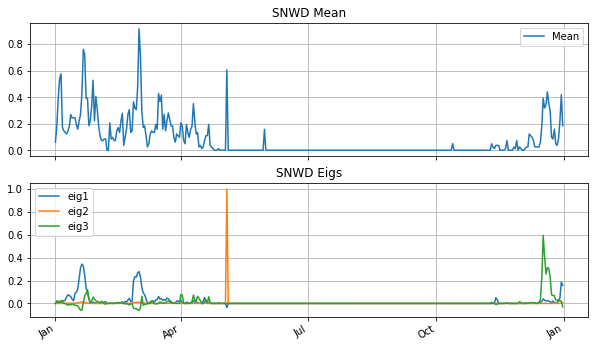

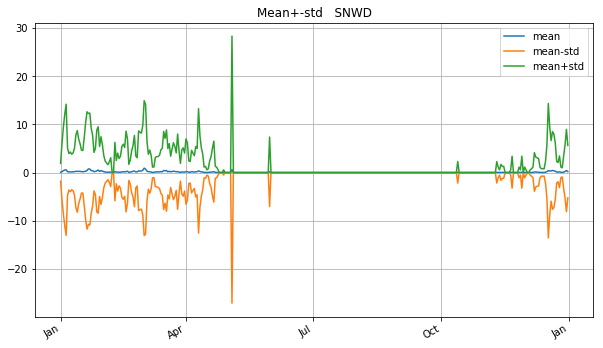

In [9]:
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6))
plot_single([m],plot_mean_std)
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')

YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

In [10]:
v=[np.array(EigVec[:,i]).flatten() for i in range(np.shape(EigVec)[1])]

In [11]:
len(v)

3

### plot the percent of residual variance on average

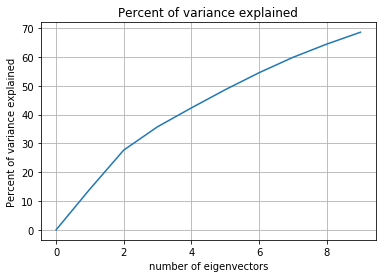

In [12]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=np.cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

## Process whole dataframe to find best and worse residuals

### Add to each row in the dataframe a residual values 
Residuals are after subtracting in sequence: the mean, the projection on the first eigen-vector the projection on the second eigen-vector etc.

`decompose(row)` axtracts the series from the row, computes the residuals and constructs a new row that is reassembled into a dataframe.


In [13]:
def decompose(row):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)


In [14]:
rdd2=df.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)
row,=df2.take(1)

#filter out vectors for which the mean is a worse approximation than zero.
print 'before filter',df2.count()
df3=df2.filter(df2.res_mean<1)
print 'after filter',df3.count()

before filter 2111
after filter 121


In [15]:
def plot_decomp(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    """Plot a single reconstruction with an informative title

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :param Mean: The mean vector of all measurements of a given type
    :param v: eigen-vectors for the distribution of measurements.
    :param fig: a matplotlib figure in which to place the plot
    :param ax: a matplotlib axis in which to place the plot
    :param Title: A plot title over-ride.
    :param interactive: A flag that indicates whether or not this is an interactive plot (widget-driven)
    :returns: a plotter returned by recon_plot initialization
    :rtype: recon_plot

    """
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='%s / %d    %s'%(row['station'],row['year'],row['measurement'])
    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

def plot_recon_grid(rows,column_n=3, row_n=1, figsize=(20,4) , resNum=1):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
#     print axes
    k=0
    for i in range(row_n):
        for j in range(column_n):
            row=rows[k]
            k+=1
            _title = 'coeff_%1.0f=%3.1f,res_3=%3.2f'%(resNum,row['coeff_'+str(resNum)],row['res_'+str(3)])
            if row_n>1:
                plot_decomp(row,Mean,v,fig=fig,ax=axes[i,j],Title=_title,interactive=False)
            else:
                plot_decomp(row,Mean,v,fig=fig,ax=axes[j],Title=_title,interactive=False)
                
    return None


In [16]:
# A function for plotting the CDF of a given feature
def plot_CDF(feat,fig=None,axis=None):
    rows=df3.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,1.00001,1./(len(vals)))
    vals=[vals[0]]+vals
    if axis:
        axis.plot(vals,P)
        axis.set_title('cumulative distribution of '+feat)
        axis.set_ylabel('number of instances')
        axis.set_xlabel(feat)
        axis.grid()
        
    else:
        plot(vals,P)
        title('cumulative distribution of '+feat)
        ylabel('number of instances')
        xlabel(feat)
        grid()

# A function for plotting the CDF of a given feature
def plot_CDF_filter(feat,fig=None,axis=None):
    rows=df3.filter(df3.res_3<0.8).select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,1.00001,1./(len(vals)))
    vals=[vals[0]]+vals
    if axis:
        axis.plot(vals,P)
        axis.set_title('cumulative distribution of '+feat + " with res_3 < 0.8")
        axis.set_ylabel('number of instances')
        axis.set_xlabel(feat)
        axis.grid()
    else:
        plot(vals,P)
        title('cumulative distribution of '+feat)
        ylabel('number of instances')
        xlabel(feat)
        grid()

def plot_cdf_grid(num,column_n=3, row_n=1, figsize=(20,8)):
    
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
#     print axes
    k=0
#         _title = 'coeff_%1.0f=%3.1f,res_3=%3.2f'%(resNum,row['coeff_'+str(resNum)],row['res_'+str(3)])
#         else:
    plot_CDF('res_'+str(num),fig,axes[0])
    plot_CDF('coeff_'+str(num),fig,axes[1])
    plot_CDF_filter('coeff_'+str(num),fig,axes[2])
                
    return None

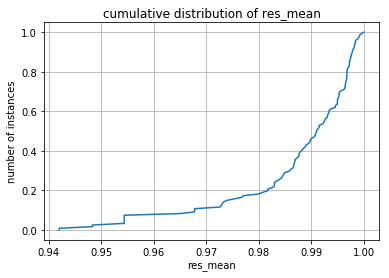

In [17]:
plot_CDF('res_mean')

In [18]:
# Sort entries by increasing values of ers_3
df3=df3.sort(df3.res_3,ascending=True)

## Coeff 1


In [37]:
df4=df3.filter(df3.res_3<1.0).sort(df3.coeff_1)
rows=df4.take(3)
df4.select('coeff_1','res_1').show(4)

+-------------------+------------------+
|            coeff_1|             res_1|
+-------------------+------------------+
|-48.442461733773364|0.9985436760237267|
|-2.3181530076788293|0.9999506689271943|
|-2.1983798219538757|0.9997907066988675|
| -2.181831547363389| 0.999542421365108|
+-------------------+------------------+
only showing top 4 rows



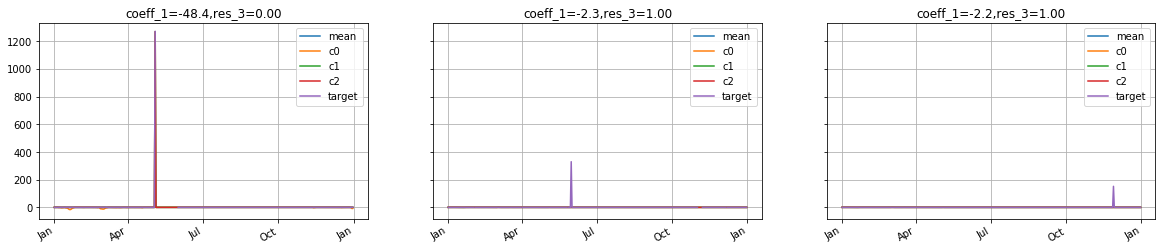

In [39]:
plot_recon_grid(rows)

In [40]:
df5=df3.filter(df3.res_3<1.0).sort(df3.coeff_1,ascending=False)
rows=df5.take(3)
df5.select('coeff_1','res_1').show(4)

+------------------+-------------------+
|           coeff_1|              res_1|
+------------------+-------------------+
|1093.2751145129887|0.09780436205392075|
| 331.1581695269779| 0.8011328163124879|
|289.72557848877204| 0.8236458076764112|
|266.46039992815804| 0.8725520640375768|
+------------------+-------------------+
only showing top 4 rows



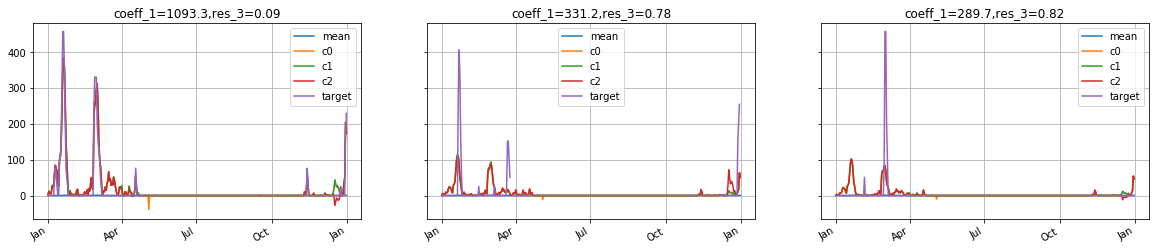

In [41]:
plot_recon_grid(rows)

In [32]:
row=rows[0]
target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
eigen_decomp=Eigen_decomp(None,target,Mean,v)
print eigen_decomp.coeff
total_var,residuals,reductions,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print 'residual normalized norm  after mean:',res[0]
print 'residual normalized norm  after mean + top eigs:',res[1:]

# plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
# display(plotter.get_Interactive())

IndexError: list index out of range

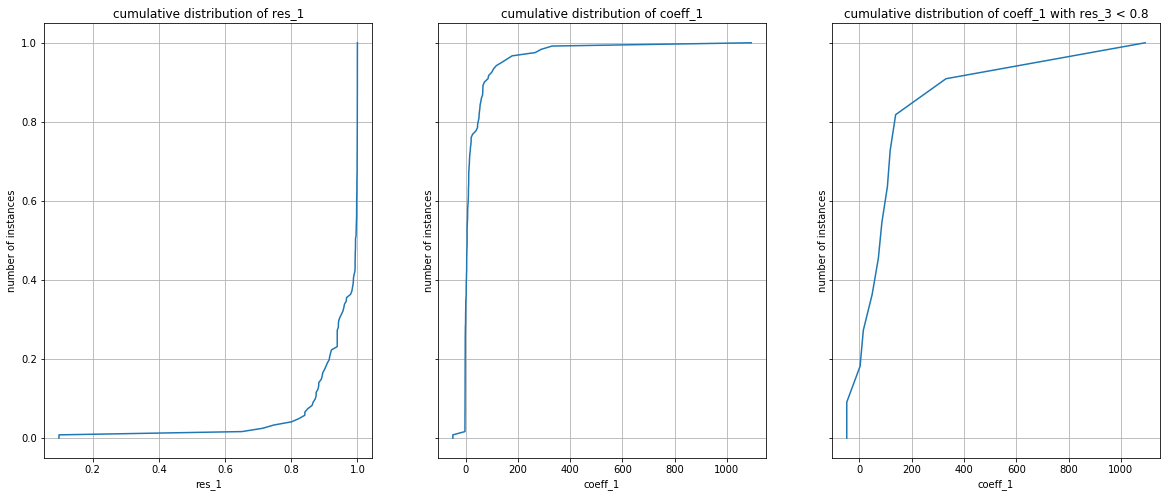

In [23]:
plot_cdf_grid(1)

## Coeff 2


In [42]:
df4=df3.filter(df3.res_3<1.0).sort(df3.coeff_2)
rows=df4.take(3)
df4.select('coeff_2','res_2').show(4)

+-------------------+------------------+
|            coeff_2|             res_2|
+-------------------+------------------+
|-1.0274801889716332| 0.999898657889172|
|-1.0194151700096985|0.9995301068568736|
|-0.9470725114841586|0.9999913137074006|
|-0.7963979538713993|0.9994594026443251|
+-------------------+------------------+
only showing top 4 rows



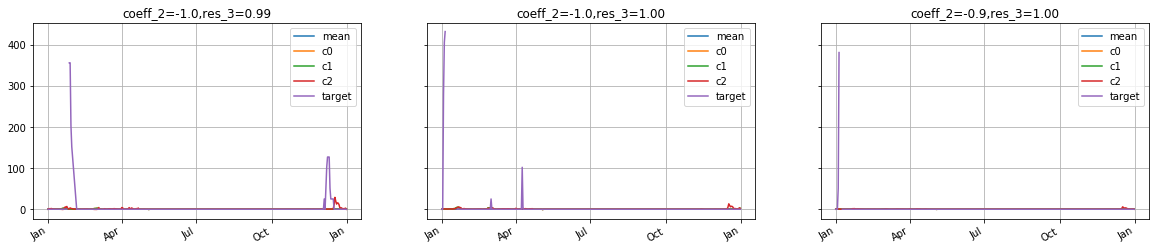

In [44]:
plot_recon_grid(rows,resNum=2)

In [46]:
df4=df3.filter(df3.res_3<1.0).sort(df3.coeff_2,ascending=False)
rows=df4.take(3)
df4.select('coeff_2','res_2').show(4)

+------------------+--------------------+
|           coeff_2|               res_2|
+------------------+--------------------+
|1268.4721659434272|2.242359578352835...|
| 39.97190059261955| 0.09659835070402112|
|11.099908511489057|  0.8009025646775153|
|  9.73579712706001|  0.8234466692174502|
+------------------+--------------------+
only showing top 4 rows



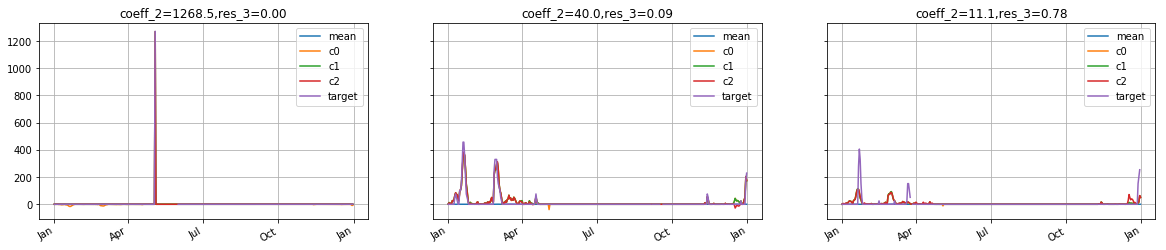

In [48]:
plot_recon_grid(rows,resNum=2)

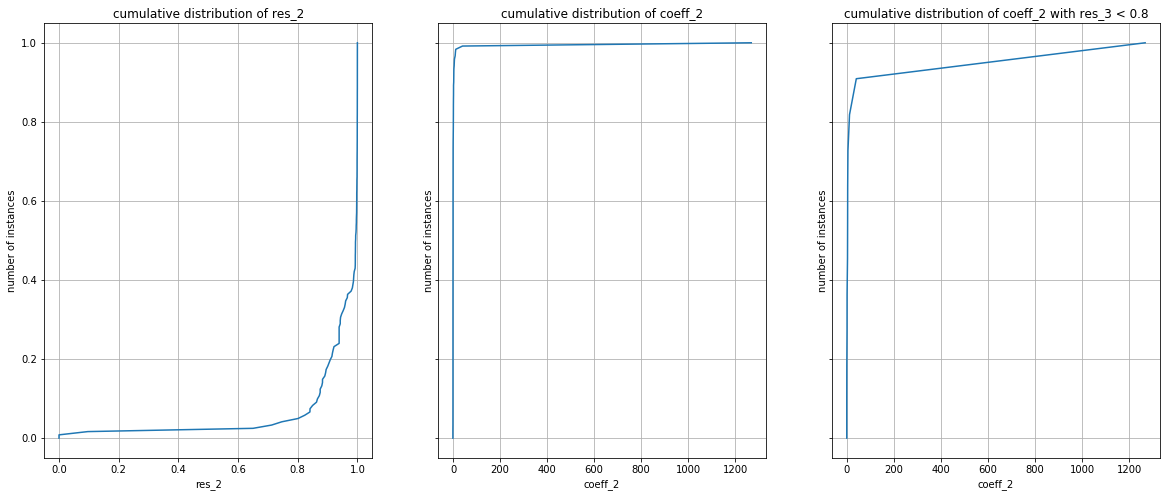

In [28]:
plot_cdf_grid(2)

## Coeff 3


In [49]:
df4=df3.filter(df3.res_3<1.0).sort(df3.coeff_3)
rows=df4.take(3)
df4.select('coeff_3','res_3').show(4)

+-------------------+-------------------+
|            coeff_3|              res_3|
+-------------------+-------------------+
|-119.68554845265135|0.08578587296882396|
| -39.73668811242548| 0.8201292875053284|
|-30.215887888979278| 0.8617854056115282|
| -21.98228396701681| 0.8715506208326148|
+-------------------+-------------------+
only showing top 4 rows



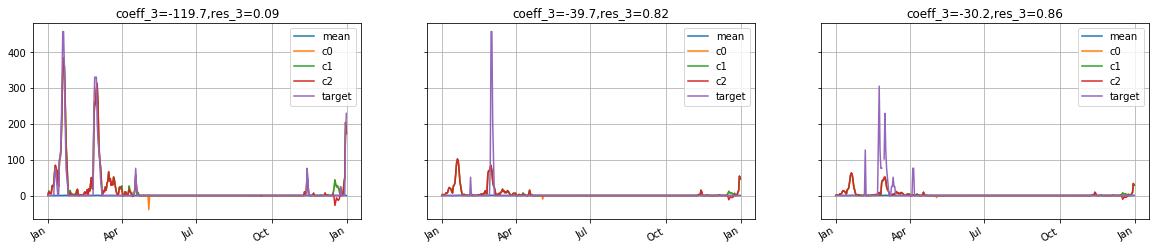

In [50]:
plot_recon_grid(rows,resNum=3)

In [52]:
df4=df3.filter(df3.res_3<1.0).sort(df3.coeff_3,ascending=False)
rows=df4.take(3)
df4.select('coeff_3','res_3').show(4)

+------------------+------------------+
|           coeff_3|             res_3|
+------------------+------------------+
| 839.1791051914702|0.0995889159047593|
|308.40913868762794|0.5564721387596826|
| 293.7170729571813|0.7174108164525048|
|114.17071415531419|0.7215091868754017|
+------------------+------------------+
only showing top 4 rows



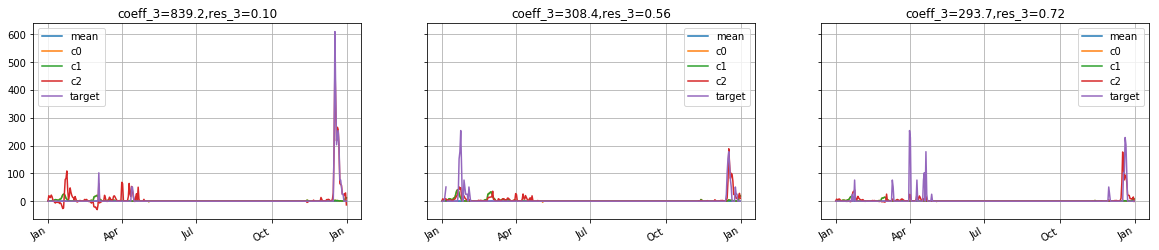

In [53]:
plot_recon_grid(rows,resNum=3)

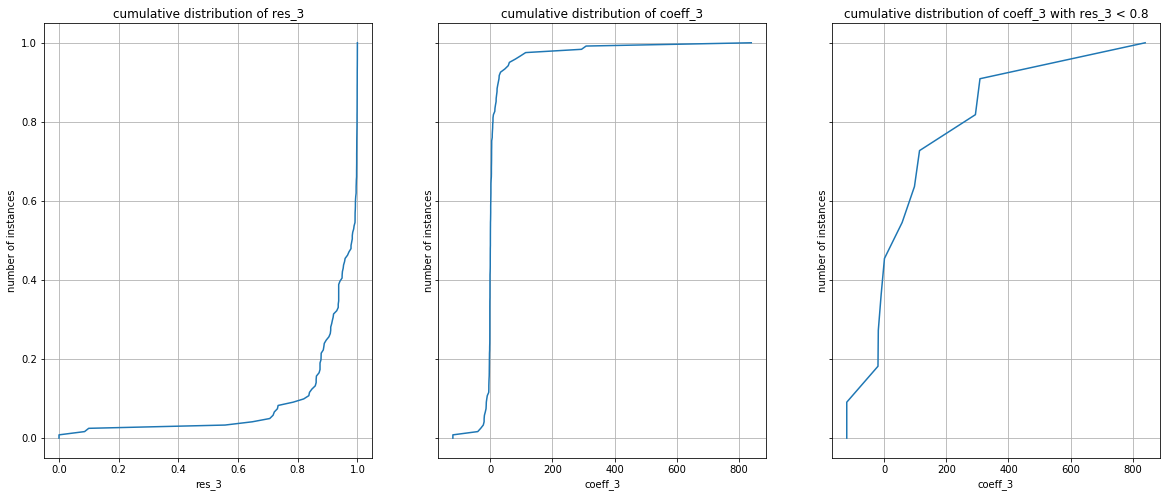

In [33]:
plot_cdf_grid(3)

In [34]:
# filename=data_dir+'/decon_'+file_index+'_'+m+'.parquet'
# !rm -rf $filename
# df3.write.parquet(filename)

In [55]:
#extract longitude and latitude for each station
def RMS(Mat):
    return np.sqrt(np.nanmean(Mat**2))

# sqlContext.registerDataFrameAsTable(df,'weather')

#Features=', '.join(['coeff_1', 'coeff_2', 'coeff_3', 'elevation', 'latitude', 'longitude',\
#          'res_1', 'res_2', 'res_3', 'res_mean', 'year'])
for feature in ['coeff_1','coeff_2','coeff_3']:
    Features=['station', 'year', feature]
    _df = df3.select(Features)
#     Query="SELECT %s FROM weather"%Features
#     print(Query)
#     pdf = sqlContext.sql(Query).toPandas()
    pdf = _df.toPandas()
    # pdf.head()
    year_station_table=pdf.pivot(index='year', columns='station', values=feature)
    # year_station_table.head(10)
    mean_by_year=np.nanmean(year_station_table,axis=1)
    mean_by_station=np.nanmean(year_station_table,axis=0)
    tbl_minus_year = (year_station_table.transpose()-mean_by_year).transpose()
    rms_yr = RMS(tbl_minus_year)
    tbl_minus_station = year_station_table-mean_by_station
    rms_st = RMS(tbl_minus_station)
    rms = RMS(year_station_table)

    print feature
    print 'total RMS                   = ', rms
    print 'RMS removing mean-by-station= ', rms_st,  'variance explained', (rms**2-rms_st**2)/rms**2
    print 'RMS removing mean-by-year   = ', rms_yr,  'variance explained', (rms**2-rms_yr**2)/rms**2

coeff_1
total RMS                   =  116.684503353
RMS removing mean-by-station=  106.845641599 variance explained 0.161530521055
RMS removing mean-by-year   =  90.6737042297 variance explained 0.39613987587
coeff_2
total RMS                   =  115.389616809
RMS removing mean-by-station=  111.496415332 variance explained 0.0663408722557
RMS removing mean-by-year   =  81.6515975456 variance explained 0.499278879573
coeff_3
total RMS                   =  88.6817548982
RMS removing mean-by-station=  85.5573437346 variance explained 0.0692221747372
RMS removing mean-by-year   =  26.1007651838 variance explained 0.9133760623


In [62]:
mean_by_year.shape

(55,)

In [64]:
rows=df.rdd.map(lambda row:(row.station,row.year,unpackArray(row['vector'],np.float16))).collect()
days=set([r[1] for r in rows])
miny=min(days)
maxy=max(days)
record_len=int((maxy-miny+1)*365)
record_len
## combine the measurements for each station into a single long array with an entry for each day of each day
All={}  # a dictionary with a numpy array for each day of each day
i=0
for station,day,vector in rows:
    i+=1; 
    # if i%1000==0: print i,len(All)
    if not station in All:
        a=np.zeros(record_len)
        a.fill(np.nan)
        All[station]=a
    loc = int((day-miny)*365)
    All[station][loc:loc+365]=vector
from datetime import date
d=datetime.date(int(miny), month=1, day=1)
start=d.toordinal()
dates=[date.fromordinal(i) for i in range(start,start+record_len)]
Stations=sorted(All.keys())
A=[]
for station in Stations:
    A.append(All[station])

day_station_table=np.hstack([A])
print shape(day_station_table)

(68, 40150)


In [65]:
mean_by_day=np.nanmean(day_station_table,axis=0)
mean_by_station=np.nanmean(day_station_table,axis=1)
tbl_minus_day = day_station_table-mean_by_day
tbl_minus_station = (day_station_table.transpose()-mean_by_station).transpose()

print 'total RMS                   = ',RMS(day_station_table)
print 'RMS removing mean-by-station= ',RMS(tbl_minus_station)
print 'RMS removing mean-by-day   = ',RMS(tbl_minus_day)

total RMS                   = 

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


 3.94595071258
RMS removing mean-by-station=  3.92436259976
RMS removing mean-by-day   =  3.8722496998


(761708,) (761708,)


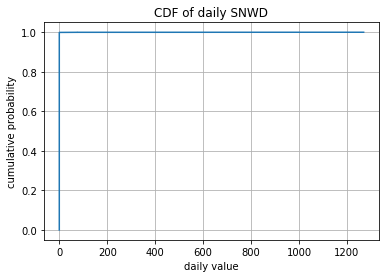

In [66]:
RT=day_station_table
F=RT.flatten()
NN=F[~np.isnan(F)]

NN.sort()
P=np.arange(0.,1.,1./len(NN))
NN = NN[:min(len(P),len(NN))]
P = P[:len(NN)]
print NN.shape,P.shape
plot(NN,P)
grid()
title('CDF of daily %s'%(m))
xlabel('daily value')
ylabel('cumulative probability')

(68, 40150)
(68, 68)
<class 'pandas.core.frame.DataFrame'> (68, 68)
(68, 68)


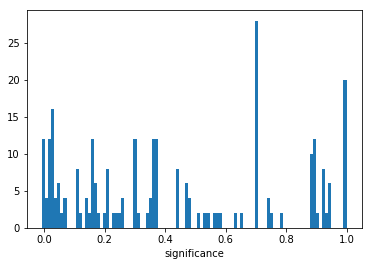

In [67]:
import pandas as pd 
print day_station_table.shape
P_norm=pd.DataFrame(day_station_table.T).corr()
print P_norm.shape
# print P_norm
print type(P_norm),P_norm.shape
P_norm = P_norm.as_matrix()
for i in range(len(P_norm)):
    P_norm[i,i]=np.nan
print P_norm.shape
A=P_norm.flatten();
B=A[~isnan(A)]
B=[x for x in B if x > 0.001 or x < -0.001]
# print B
# print A.shape,B.shape
hist(B,bins=100);
xlabel('significance')

In [80]:
day_station_table.shape

(68, 40150)

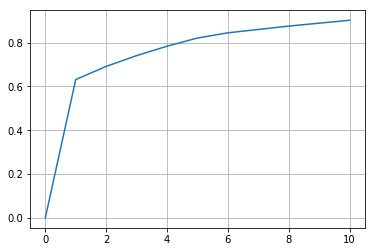

In [68]:
from sklearn.decomposition import PCA
P_norm0 = np.nan_to_num(P_norm)
n_comp=10
pca = PCA(n_components=n_comp, svd_solver='full')
pca.fit(P_norm0)     
#print(pca.explained_variance_)
Var_explained=pca.explained_variance_ratio_
plot(insert(cumsum(Var_explained),0,0))
grid()

In [69]:
# we will look only at the top 4 eigenvectors.
n_comp=4
pca = PCA(n_components=n_comp, svd_solver='full')
pca.fit(P_norm0)     

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

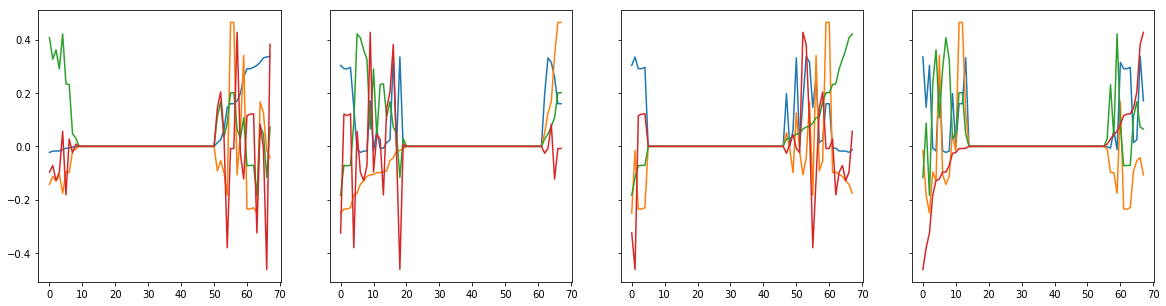

In [70]:
fig,axes=plt.subplots(1,4,figsize=(20,5),sharey='row');
L=list(pca.components_.transpose())
for i in range(4):
    X=sorted(L,key=lambda x:x[i]) 
    axes[i].plot(X);

In [71]:
def re_order_matrix(M,order):
    M_reord=M[order,:]
    M_reord=M_reord[:,order]
    return M_reord
def showmat(mat):
    fig,axes=plt.subplots(1,1,figsize=(6,6))
    axes.imshow(mat, cmap=plt.cm.Greys)

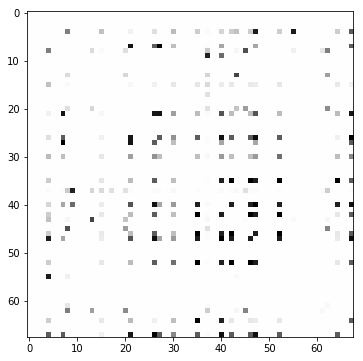

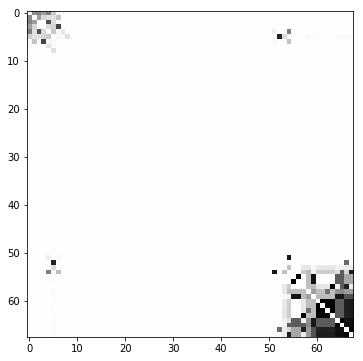

In [72]:
# fig,axes=plt.subplots(2,2,figsize=(15,15),sharex='col',sharey='row');

i=0
showmat(P_norm0)
for r in range(2):
    for c in range(2):
        order=np.argsort(pca.components_[i,:])
        P_norm_reord=re_order_matrix(P_norm0,order)
#         axes[r,c].matshow(P_norm_reord)
        showmat(P_norm_reord)
        i+=1
        break
    break

In [73]:
correlated=[]
for i in range(len(P_norm)):
    for j in range(len(P_norm)):
        if P_norm[i][j]>0.8:
            correlated+=[(i,j)]
# correlated

In [74]:
with open(data_dir+'/stations.pkl','rb') as file:
    all_stations=load(file)
all_stations=all_stations[all_stations.index.isin(Stations) ]

In [75]:
all_points = all_stations
correlated_points = []
for cor in correlated:
    correlated_points +=[ (all_stations[all_stations.index==Stations[cor[0]]],all_stations[all_stations.index==Stations[cor[1]]])]

In [69]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)
min_lat,max_lat,min_long,max_long = box = (36.1872, 37.4767, -122.4433, -120.8667)
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 8

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
# m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in all_points.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
#     _count=row['count(station)']
#     _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), 
                     radius=15, weight=5,
                    color='#F00', opacity=0.8, fill_opacity=0.4,
#                     fill_color=get_color(_coef)
                    )
    circles.append(c)
    m.add_layer(c)
for point in correlated_points:
    latlng = [
        (point  [0].latitude.values[0],point[0].longitude.values[0]),
        (point  [1].latitude.values[0],point[1].longitude.values[0])
    ]
#     print latlng
    l = Polyline(locations=latlng,weight=1)
     
#     m+=l
    m.add_layer(l)
m    

Widget Javascript not detected.  It may not be installed or enabled properly.


In [ ]:
for index,row in all_points.iterrows():
    

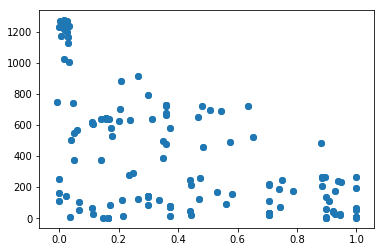

In [76]:
elevation,cor=[],[]
for i in range(len(P_norm0)):
    for j in range(len(P_norm0)):
        if P_norm0[i][j] > 0.001 or P_norm0 [i][j]< -0.001:
            elevation += [abs(all_stations[all_stations.index==Stations[i]].elevation.values[0] - all_stations[all_stations.index==Stations[j]].elevation.values[0])]
            cor += [P_norm0[i][j]]
plt.scatter(cor,elevation)
        

In [79]:
# plt.plot(list(arange(1500)),elevations)
year_station_table.shape

(55, 26)

(68, 40150)
<class 'pandas.core.frame.DataFrame'> (26, 26)
(26, 26)
(676,) (52,)


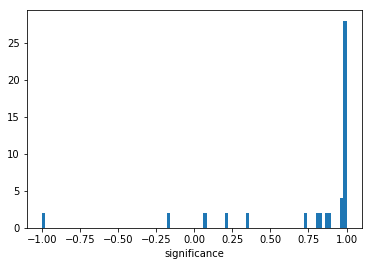

In [77]:
import pandas as pd 
print day_station_table.shape
P_norm=pd.DataFrame(year_station_table).corr()
# print P_norm
# print P_norm
print type(P_norm),P_norm.shape
P_norm = P_norm.as_matrix()
for i in range(len(P_norm)):
    P_norm[i,i]=np.nan
print P_norm.shape
A=P_norm.flatten();
B=A[~isnan(A)]
print A.shape,B.shape
B=[x for x in B if x > 0.0001 or x < -0.0001]
hist(B,bins=100);
xlabel('significance')
for i in range(len(P_norm)):
    for j in range(len(P_norm)):
        P_norm[i,j] = abs(P_norm[i,j])

(2, 4) (2, 6) (2, 13) (2, 16) (2, 17) (2, 22) (4, 2) (4, 6) (4, 13) (4, 16) (4, 22) (5, 11) (5, 13) (6, 2) (6, 4) (6, 13) (6, 16) (6, 22) (10, 13) (11, 5) (13, 2) (13, 4) (13, 5) (13, 6) (13, 10) (13, 14) (13, 22) (13, 23) (13, 24) (14, 13) (16, 2) (16, 4) (16, 6) (16, 22) (17, 2) (22, 2) (22, 4) (22, 6) (22, 13) (22, 16) (23, 13) (24, 13)


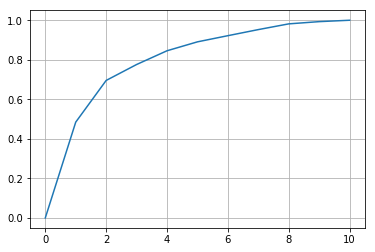

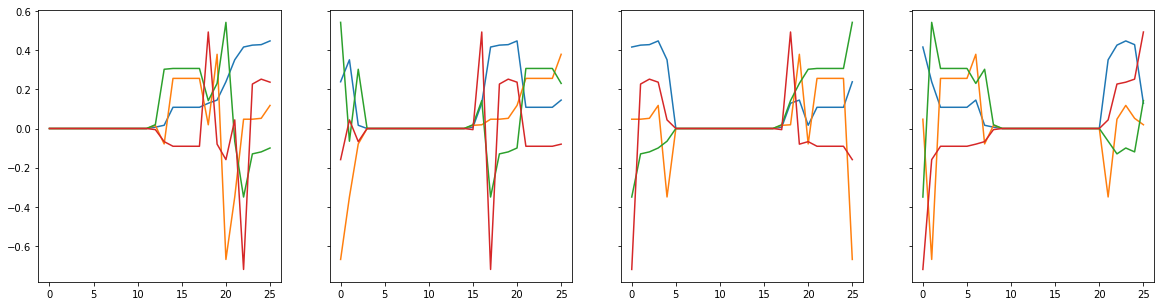

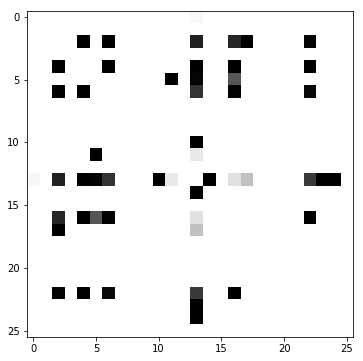

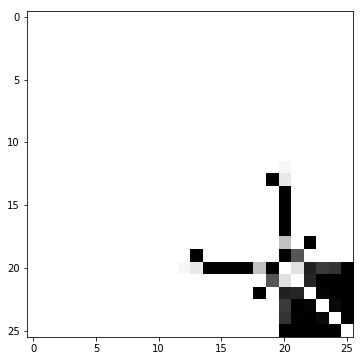

In [77]:
from sklearn.decomposition import PCA
P_norm0 = np.nan_to_num(P_norm)
n_comp=10
pca = PCA(n_components=n_comp, svd_solver='full')
pca.fit(P_norm0)     
#print(pca.explained_variance_)
Var_explained=pca.explained_variance_ratio_
plot(insert(cumsum(Var_explained),0,0))
grid()
# we will look only at the top 4 eigenvectors.
n_comp=4
pca = PCA(n_components=n_comp, svd_solver='full')
pca.fit(P_norm0)     
fig,axes=plt.subplots(1,4,figsize=(20,5),sharey='row');
L=list(pca.components_.transpose())
for i in range(4):
    X=sorted(L,key=lambda x:x[i]) 
    axes[i].plot(X);
i=0
showmat(P_norm0)
for r in range(2):
    for c in range(2):
        order=np.argsort(pca.components_[i,:])
        P_norm_reord=re_order_matrix(P_norm0,order)
#         axes[r,c].matshow(P_norm_reord)
        showmat(P_norm_reord)
        i+=1
        break
    break
correlated=[]

for i in range(len(P_norm)):
    for j in range(len(P_norm)):
        if P_norm[i][j]>0.8:
            correlated+=[(i,j)]
all_points = all_stations
correlated_points = []
for cor in correlated:
    print cor,
    correlated_points +=[ (all_stations[all_stations.index==Stations[cor[0]]],all_stations[all_stations.index==Stations[cor[1]]])]

In [78]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)
min_lat,max_lat,min_long,max_long = box = (36.1872, 37.4767, -122.4433, -120.8667)
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 8

_m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
# m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in all_points.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
#     _count=row['count(station)']
#     _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), 
                     radius=15, weight=5,
                    color='#F00', opacity=0.8, fill_opacity=0.4,
#                     fill_color=get_color(_coef)
                    )
    circles.append(c)
    _m.add_layer(c)
for point in correlated_points:
    latlng = [
        (point  [0].latitude.values[0],point[0].longitude.values[0]),
        (point  [1].latitude.values[0],point[1].longitude.values[0])
    ]
#     print latlng
    l = Polyline(locations=latlng,weight=1)
     
#     m+=l
    _m.add_layer(l)
_m    

Widget Javascript not detected.  It may not be installed or enabled properly.


In [79]:
len(correlated_points)

42

<class 'pandas.core.frame.DataFrame'> (26, 26)


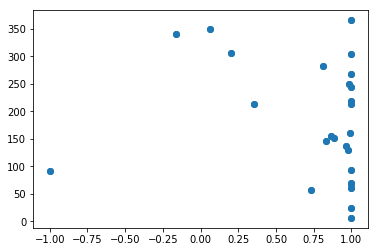

In [82]:
P_norm=pd.DataFrame(year_station_table).corr()
# print P_norm
# print P_norm
print type(P_norm),P_norm.shape
P_norm = P_norm.as_matrix()
for i in range(len(P_norm)):
    P_norm[i,i]=np.nan
    
P_norm0 = np.nan_to_num(P_norm)
elevation,cor=[],[]
for i in range(len(P_norm0)):
    for j in range(len(P_norm0)):
        if P_norm0[i][j] > 0.0001 or P_norm0[i][j] < -0.0001:
            elevation += [abs(all_stations[all_stations.index==Stations[i]].elevation.values[0] - all_stations[all_stations.index==Stations[j]].elevation.values[0])]
            cor += [P_norm0[i][j]]
plt.scatter(cor,elevation)
        